# Netflix Movie Recommendation System

## Business Problem

<p>Netflix is all about connecting people to the movies they love. To help customers find those movies, they developed world-class movie recommendation system: CinematchSM. Its job is to predict whether someone will enjoy a movie based on how much they liked or disliked other movies. Netflix use those predictions to make personal movie recommendations based on each customer’s unique tastes. And while Cinematch is doing pretty well, it can always be made better.</p>

<p>Now there are a lot of interesting alternative approaches to how Cinematch works that netflix haven’t tried. Some are described in the literature, some aren’t. We’re curious whether any of these can beat Cinematch by making better predictions. Because, frankly, if there is a much better approach it could make a big difference to our customers and our business.</p>

<p>Credits: https://www.netflixprize.com/rules.html</p>

## Problem Statement
<p>Netflix provided a lot of anonymous rating data, and a prediction accuracy bar that is 10% better than what Cinematch can do on the same training data set. (Accuracy is a measurement of how closely predicted ratings of movies match subsequent actual ratings.)</p>

## Sources
* https://www.netflixprize.com/rules.html
* https://www.kaggle.com/netflix-inc/netflix-prize-data
* Netflix blog: https://medium.com/netflix-techblog/netflix-recommendations-beyond-the-5-stars-part-1-55838468f429 (very nice blog)
* surprise library: http://surpriselib.com/ (we use many models from this library)
* surprise library doc: http://surprise.readthedocs.io/en/stable/getting_started.html (we use many models from this library)
* installing surprise: https://github.com/NicolasHug/Surprise#installation
* Research paper: http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf (most of our work was inspired by this paper)
* SVD Decomposition : https://www.youtube.com/watch?v=P5mlg91as1c

<p><b>Real world/Business Objectives and constraints</b></p> 

<p><b>Objectives:</b></p>
1.	Predict the rating that a user would give to a movie that he has not yet rated.<br>
2.	Minimize the difference between predicted and actual rating (RMSE and MAPE).

<p><b>Constraints:</b></p>
1.	Some form of interpretability.
2.	There is no low latency requirement as the recommended movies can be precomputed earlier.

<p><b>Type of Data:</b></p>
* There are 17770 unique movie IDs.
* There are 480189 unique user IDs.
* There are ratings. Ratings are on a five star (integral) scale from 1 to 5.

<p><b>Data Overview</b></p>
<b>Data files :</b><br>

1. combined_data_1.txt
2. combined_data_2.txt
3. combined_data_3.txt
4. combined_data_4.txt
5. movie_titles.csv
  
The first line of each file [combined_data_1.txt, combined_data_2.txt, combined_data_3.txt, combined_data_4.txt] contains the movie id followed by a colon. Each subsequent line in the file corresponds to a customerID, rating from a customer and its date.

<p style = "font-size: 22px"><b>Example Data Point</b></p>
<pre>
1:
1488844,3,2005-09-06
822109,5,2005-05-13
885013,4,2005-10-19
30878,4,2005-12-26
823519,3,2004-05-03
893988,3,2005-11-17
124105,4,2004-08-05
1248029,3,2004-04-22
1842128,4,2004-05-09
2238063,3,2005-05-11
1503895,4,2005-05-19
2207774,5,2005-06-06
2590061,3,2004-08-12
2442,3,2004-04-14
543865,4,2004-05-28
1209119,4,2004-03-23
804919,4,2004-06-10
1086807,3,2004-12-28
1711859,4,2005-05-08
372233,5,2005-11-23
1080361,3,2005-03-28
1245640,3,2005-12-19
558634,4,2004-12-14
2165002,4,2004-04-06
1181550,3,2004-02-01
1227322,4,2004-02-06
427928,4,2004-02-26
814701,5,2005-09-29
808731,4,2005-10-31
662870,5,2005-08-24
337541,5,2005-03-23
786312,3,2004-11-16
1133214,4,2004-03-07
1537427,4,2004-03-29
1209954,5,2005-05-09
2381599,3,2005-09-12
525356,2,2004-07-11
1910569,4,2004-04-12
2263586,4,2004-08-20
2421815,2,2004-02-26
1009622,1,2005-01-19
1481961,2,2005-05-24
401047,4,2005-06-03
2179073,3,2004-08-29
1434636,3,2004-05-01
93986,5,2005-10-06
1308744,5,2005-10-29
2647871,4,2005-12-30
1905581,5,2005-08-16
2508819,3,2004-05-18
1578279,1,2005-05-19
1159695,4,2005-02-15
2588432,3,2005-03-31
2423091,3,2005-09-12
470232,4,2004-04-08
2148699,2,2004-06-05
1342007,3,2004-07-16
466135,4,2004-07-13
2472440,3,2005-08-13
1283744,3,2004-04-17
1927580,4,2004-11-08
716874,5,2005-05-06
4326,4,2005-10-29
</pre>

## Mapping the real world problem to a Machine Learning Problem

<p><b>Type of Machine Learning Problem</b></p>
<p>
For a given movie and user we need to predict the rating would be given by him/her to the movie. 
The given problem is a Recommendation problem 
It can also seen as a Regression problem 
</p>

<p><b>Performance metric</b></p>
1. Mean Absolute Percentage Error
2. Root Mean Square Error


<p><b>Machine Learning Objective and Constraints</b></p>
1. Try to Minimize RMSE
2. Provide some form of interpretability

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
import os
import random
import matplotlib
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error


import xgboost as xgb
from surprise import Reader, Dataset
from surprise import BaselineOnly
from surprise import KNNBaseline
from surprise import SVD
from surprise import SVDpp
from surprise.model_selection import GridSearchCV

## 1. Reading and Storing Data

### Data Pre-processing

In [2]:
if not os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixRatings.csv"): 
    data = open(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixRatings.csv", mode = "w")
    files = [r"C:\Users\Vivek Raj\Desktop\project\netflix\combined_data_2.txt", r"C:\Users\Vivek Raj\Desktop\project\netflix\combined_data_4.txt"]
    for file in files:
        with open(file) as f:  
            for line in f:
                line = line.strip()
                if line.endswith(":"):
                    movieID = line.replace(":", "") 
                else:
                    row = [] 
                    row = [x for x in line.split(",")] 
                    row.insert(0, movieID)
                    data.write(",".join(row))
                    data.write("\n")
        
    data.close()

In [3]:
# creating data frame from our output csv file.
if not os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixData.pkl"):
    Final_Data = pd.read_csv(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixRatings.csv", sep=",", names = ["MovieID","CustID", "Ratings", "Date"])
    Final_Data["Date"] = pd.to_datetime(Final_Data["Date"])
    Final_Data.sort_values(by = "Date", inplace = True)
    

In [4]:
# storing pandas dataframe as a picklefile for later use
if not os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixData.pkl"):
    Final_Data.to_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixData.pkl")
else:
    Final_Data = pd.read_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\NetflixData.pkl")

In [5]:
Final_Data.head()

,MovieID,CustID,Ratings,Date
49557332,17064,510180,2,1999-11-11
46370047,16465,510180,3,1999-11-11
22463125,8357,510180,4,1999-11-11
35237815,14660,510180,2,1999-11-11
21262258,8079,510180,2,1999-11-11


In [6]:
Final_Data.describe()["Ratings"]

count    5.382511e+07
mean     3.606058e+00
std      1.082326e+00
min      1.000000e+00
25%      3.000000e+00
50%      4.000000e+00
75%      4.000000e+00
max      5.000000e+00
Name: Ratings, dtype: float64

In [7]:
Final_Data.describe()

,MovieID,CustID,Ratings
count,5.382511e+07,5.382511e+07,5.382511e+07
mean,1.113493e+04,1.322515e+06,3.606058e+00
std,4.577057e+03,7.645207e+05,1.082326e+00
min,4.500000e+03,6.000000e+00,1.000000e+00
25%,6.692000e+03,6.613310e+05,3.000000e+00
50%,9.205000e+03,1.319107e+06,4.000000e+00
75%,1.545000e+04,1.984445e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


In [8]:
Final_Data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53825114 entries, 49557332 to 17495310
Data columns (total 4 columns):
 #   Column   Dtype         
---  ------   -----         
 0   MovieID  int64         
 1   CustID   int64         
 2   Ratings  int64         
 3   Date     datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 2.0 GB


### Checking for NaN

In [9]:
print("Number of NaN values = "+str(Final_Data.isnull().sum()))

Number of NaN values = MovieID    0
CustID     0
Ratings    0
Date       0
dtype: int64


### Removing Duplicates

In [10]:
duplicates = Final_Data.duplicated(["MovieID","CustID", "Ratings"])
print("Number of duplicate rows = "+str(duplicates.sum()))

Number of duplicate rows = 0


### Basic Statistics

In [11]:
print("Total Data:")
print("Total number of movie ratings = "+str(Final_Data.shape[0]))
print("Number of unique users = "+str(len(np.unique(Final_Data["CustID"]))))
print("Number of unique movies = "+str(len(np.unique(Final_Data["MovieID"]))))

Total Data:
Total number of movie ratings = 53825114
Number of unique users = 478723
Number of unique movies = 9114


### Spliting data into Train and Test(80:20)

In [37]:
if not os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainData.pkl"):
    Final_Data.iloc[:int(Final_Data.shape[0]*0.80)].to_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainData.pkl")
    Train_Data = pd.read_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)
else:
    Train_Data = pd.read_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainData.pkl")
    Train_Data.reset_index(drop = True, inplace = True)

if not os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestData.pkl"):
    Final_Data.iloc[int(Final_Data.shape[0]*0.80):].to_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestData.pkl")
    Test_Data = pd.read_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)
else:
    Test_Data = pd.read_pickle(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestData.pkl")
    Test_Data.reset_index(drop = True, inplace = True)

### Basic Statistics in Train data

In [38]:
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,17064,510180,2,1999-11-11
1,16465,510180,3,1999-11-11
2,8357,510180,4,1999-11-11
3,14660,510180,2,1999-11-11
4,8079,510180,2,1999-11-11


In [39]:
Train_Data.describe()

,MovieID,CustID,Ratings
count,4.306009e+07,4.306009e+07,4.306009e+07
mean,1.112464e+04,1.321580e+06,3.584494e+00
std,4.566439e+03,7.646501e+05,1.079506e+00
min,4.500000e+03,6.000000e+00,1.000000e+00
25%,6.692000e+03,6.608340e+05,3.000000e+00
50%,9.189000e+03,1.317026e+06,4.000000e+00
75%,1.542800e+04,1.983679e+06,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00


In [40]:
print("Total Train Data:")
print("Total number of movie ratings in train data = "+str(Train_Data.shape[0]))
print("Number of unique users in train data = "+str(len(np.unique(Train_Data["CustID"]))))
print("Number of unique movies in train data = "+str(len(np.unique(Train_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Train_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Train_Data["MovieID"].values)))

Total Train Data:
Total number of movie ratings in train data = 43060091
Number of unique users in train data = 401901
Number of unique movies in train data = 8931
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


### Basic Statistics in Test data

In [41]:
Test_Data.head()

,MovieID,CustID,Ratings,Date
0,17405,1557557,4,2005-08-09
1,13462,2017421,4,2005-08-09
2,6475,934053,4,2005-08-09
3,6007,1156578,5,2005-08-09
4,5085,2311323,4,2005-08-09


In [42]:
print("Total Test Data:")
print("Total number of movie ratings in Test data = "+str(Test_Data.shape[0]))
print("Number of unique users in Test data = "+str(len(np.unique(Test_Data["CustID"]))))
print("Number of unique movies in Test data = "+str(len(np.unique(Test_Data["MovieID"]))))
print("Highest value of a User ID = "+str(max(Test_Data["CustID"].values)))
print("Highest value of a Movie ID = "+str(max(Test_Data["MovieID"].values)))

Total Test Data:
Total number of movie ratings in Test data = 10765023
Number of unique users in Test data = 327355
Number of unique movies in Test data = 9107
Highest value of a User ID = 2649429
Highest value of a Movie ID = 17770


## 2. Exploratory Data Analysis on Train Data

In [43]:
def Barplot(df,y,z):
    plt.figure(figsize=(10,5))
    sns.countplot(x=y,data=df)
    plt.title("Distribution of Ratings",fontsize=20)
    plt.xlabel(z)
    plt.ylabel("Number of Movies")
    plt.show()

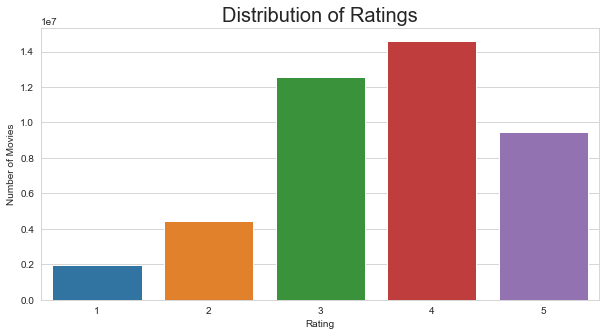

In [44]:
Barplot(Train_Data,"Ratings","Rating")

In [45]:
x=Train_Data.copy()

In [46]:
Final_Data['month'] = Final_Data.Date.dt.month
Final_Data['year'] = Final_Data.Date.dt.year
Final_Data['weekday'] = Final_Data.Date.dt.dayofweek
Final_Data.describe()

,MovieID,CustID,Ratings,month,year,weekday
count,5.382511e+07,5.382511e+07,5.382511e+07,5.382511e+07,5.382511e+07,5.382511e+07
mean,1.113493e+04,1.322515e+06,3.606058e+00,6.730142e+00,2.004245e+03,2.618791e+00
std,4.577057e+03,7.645207e+05,1.082326e+00,3.368249e+00,1.035768e+00,1.941509e+00
min,4.500000e+03,6.000000e+00,1.000000e+00,1.000000e+00,1.999000e+03,0.000000e+00
25%,6.692000e+03,6.613310e+05,3.000000e+00,4.000000e+00,2.004000e+03,1.000000e+00
50%,9.205000e+03,1.319107e+06,4.000000e+00,7.000000e+00,2.005000e+03,2.000000e+00
75%,1.545000e+04,1.984445e+06,4.000000e+00,1.000000e+01,2.005000e+03,4.000000e+00
max,1.777000e+04,2.649429e+06,5.000000e+00,1.200000e+01,2.005000e+03,6.000000e+00


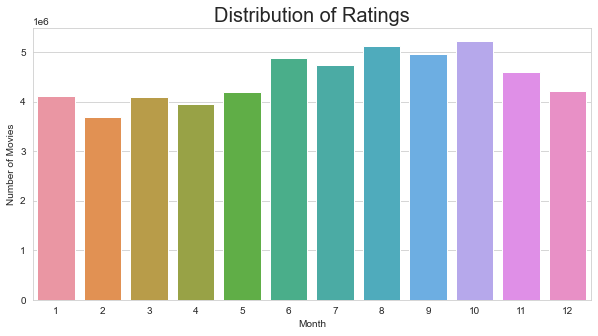

In [47]:
Barplot(Final_Data,"month","Month")

In [48]:
years=np.unique(Final_Data.year)
years=list(years)
years

[1999, 2000, 2001, 2002, 2003, 2004, 2005]

1999


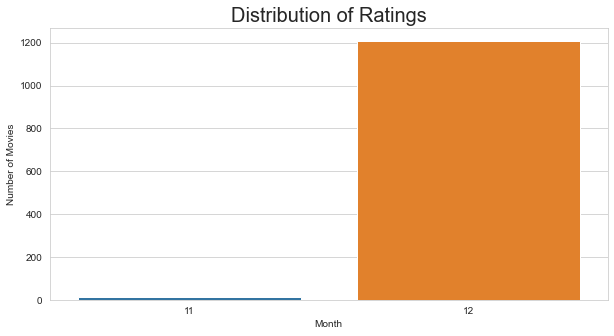

2000


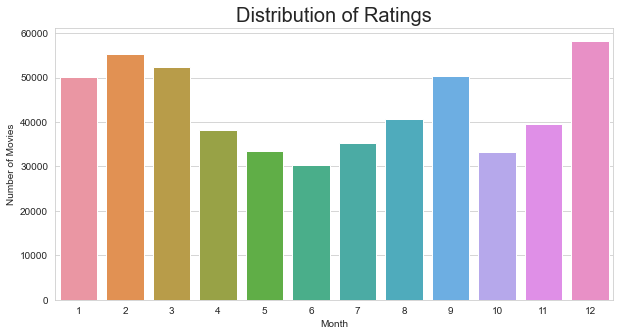

2001


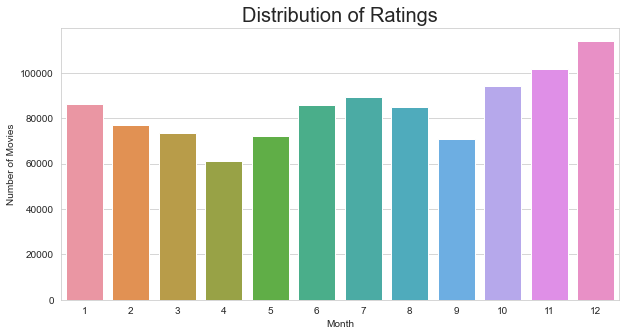

2002


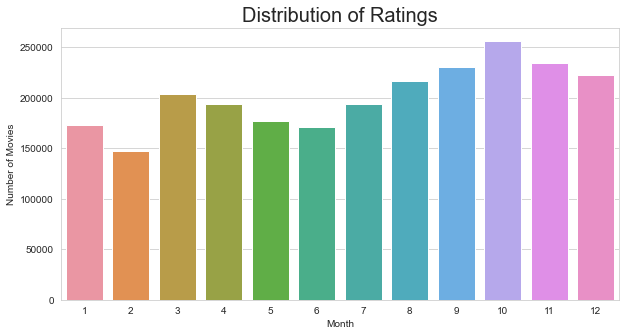

2003


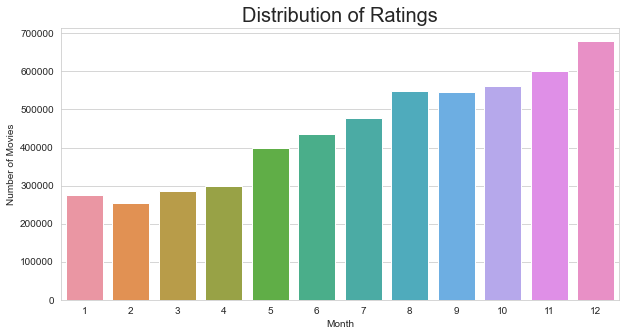

2004


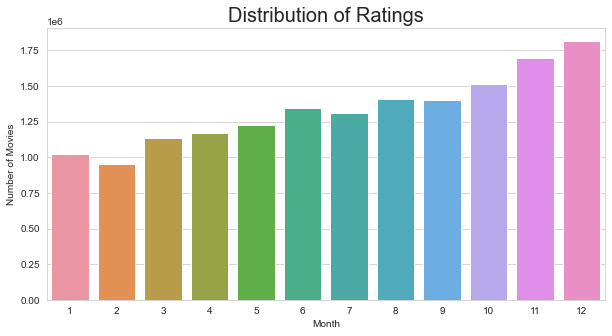

2005


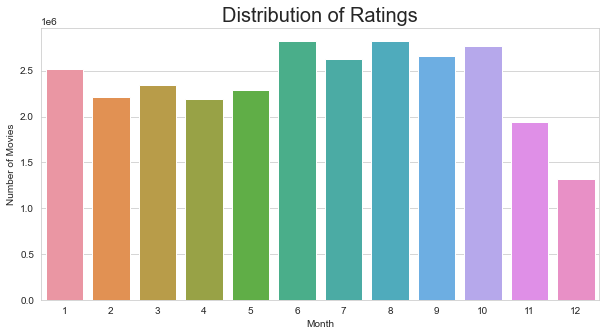

In [49]:
for i in years:
    print(i)
    Barplot(Final_Data[Final_Data.year==i],"month","Month")

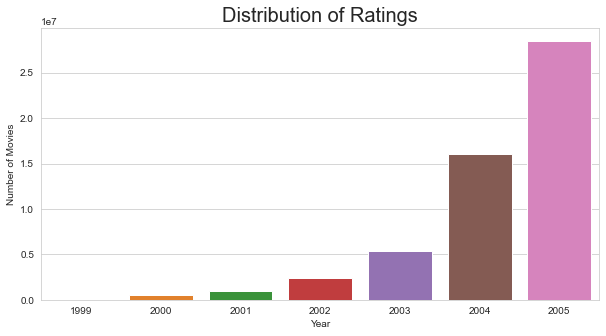

In [50]:
Barplot(Final_Data,"year","Year")

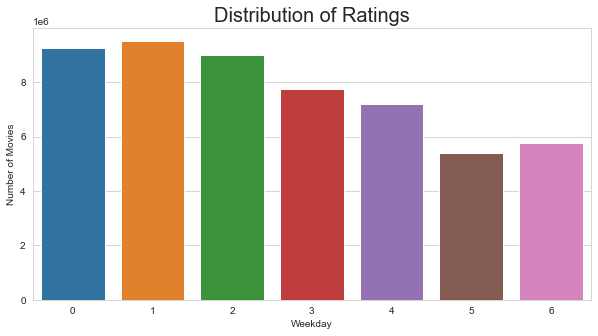

In [51]:
Barplot(Final_Data,"weekday","Weekday")

In [52]:
Train_Data.head()

,MovieID,CustID,Ratings,Date
0,17064,510180,2,1999-11-11
1,16465,510180,3,1999-11-11
2,8357,510180,4,1999-11-11
3,14660,510180,2,1999-11-11
4,8079,510180,2,1999-11-11


### Analysis of Ratings given by user

In [53]:
no_of_rated_movies_per_user = Train_Data.groupby(by = "CustID")["Ratings"].count().sort_values(ascending = False)

In [54]:
no_of_rated_movies_per_user.head()

CustID
305344     8779
2439493    8126
387418     7884
1639792    4983
1461435    4846
Name: Ratings, dtype: int64

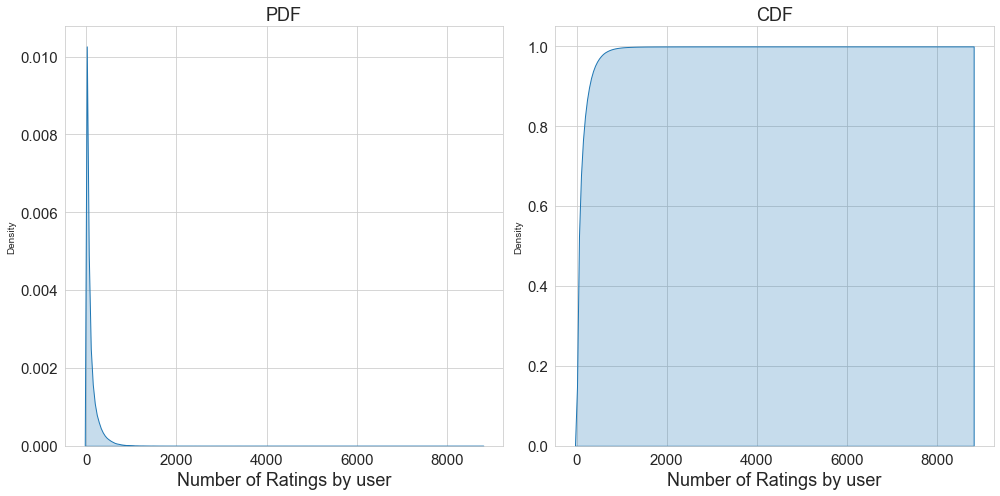

In [55]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(14,7))

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, ax = axes[0])
axes[0].set_title("PDF", fontsize = 18)
axes[0].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[0].tick_params(labelsize = 15)

sns.kdeplot(no_of_rated_movies_per_user.values, shade = True, cumulative = True, ax = axes[1])
axes[1].set_title("CDF", fontsize = 18)
axes[1].set_xlabel("Number of Ratings by user", fontsize = 18)
axes[1].tick_params(labelsize = 15)

fig.subplots_adjust(wspace=2)
plt.tight_layout()
plt.show()

* Above PDF graph shows that almost all of the users give very few ratings. There are very few users who's ratings count is high.
* Similarly, above CDF graph shows that almost 99% of users give very few ratings.

In [56]:
print("Information about movie ratings grouped by users:")
no_of_rated_movies_per_user.describe()

Information about movie ratings grouped by users:


count    401901.00000
mean        107.14104
std         155.05350
min           1.00000
25%          19.00000
50%          48.00000
75%         133.00000
max        8779.00000
Name: Ratings, dtype: float64

### Analysis of Ratings Per Movie

In [57]:
no_of_ratings_per_movie = Train_Data.groupby(by = "MovieID")["Ratings"].count().sort_values(ascending = False)

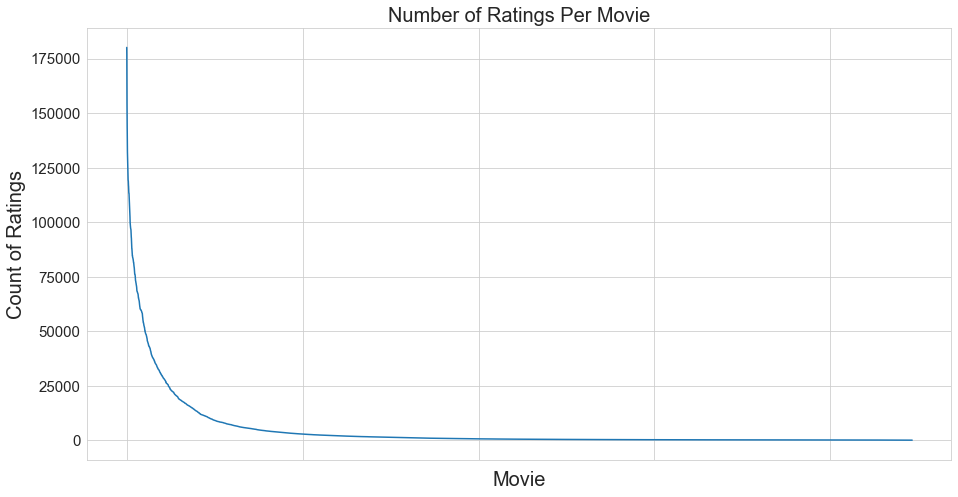

In [58]:
fig = plt.figure(figsize = (12, 6))
axes = fig.add_axes([0.1,0.1,1,1])
plt.title("Number of Ratings Per Movie", fontsize = 20)
plt.xlabel("Movie", fontsize = 20)
plt.ylabel("Count of Ratings", fontsize = 20)
plt.plot(no_of_ratings_per_movie.values)
plt.tick_params(labelsize = 15)
axes.set_xticklabels([])
plt.show()

<b>It is very skewed</b>
<p>It clearly shows that there are some movies which are very popular and were rated by many users as comapared to other movies</p>

### Analysis of Movie Ratings on Day of Week

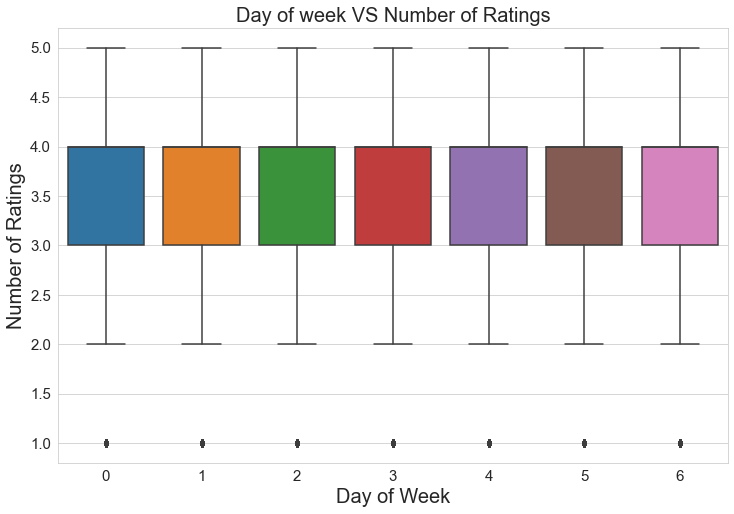

In [59]:
fig = plt.figure(figsize = (12, 8))
Train_Data["weekday"]=Train_Data.Date.dt.dayofweek
axes = sns.boxplot(x = "weekday", y = "Ratings", data = Train_Data)
axes.set_title("Day of week VS Number of Ratings", fontsize = 20)
axes.set_xlabel("Day of Week", fontsize = 20)
axes.set_ylabel("Number of Ratings", fontsize = 20)
axes.tick_params(labelsize = 15)

plt.show()

In [60]:

average_ratings_dayofweek = Train_Data.groupby(by = "weekday")["Ratings"].mean()
print("Average Ratings on Day of Weeks")
print(average_ratings_dayofweek)

Average Ratings on Day of Weeks
weekday
0    3.577235
1    3.574852
2    3.585002
3    3.583570
4    3.589555
5    3.595120
6    3.596637
Name: Ratings, dtype: float64


## 3. Creating USER-ITEM sparse matrix from data frame

In [61]:

if os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainUISparseData.npz"):
    TrainUISparseData = sparse.load_npz(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainUISparseData.npz")
else:
    TrainUISparseData = sparse.csr_matrix((Train_Data.Ratings, (Train_Data.CustID, Train_Data.MovieID)))
    sparse.save_npz(r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainUISparseData.npz", TrainUISparseData)

In [62]:

if os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestUISparseData.npz"):
    TestUISparseData = sparse.load_npz(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestUISparseData.npz")
else:
    TestUISparseData = sparse.csr_matrix((Test_Data.Ratings, (Test_Data.CustID, Test_Data.MovieID)))
    sparse.save_npz(r"C:\Users\Vivek Raj\Desktop\project\netflix\TestUISparseData.npz", TestUISparseData)

In [63]:
#If you can see above that the shape of both train and test sparse matrices are same, furthermore, how come this shape of sparse
#matrix has arrived:
#Shape of sparse matrix depends on highest value of User ID and highest value of Movie ID. 
#Now the user whose user ID is highest is present in both train data and test data. Similarly, the movie whose movie ID is
#highest is present in both train data and test data. Hence, shape of both train and test sparse matrices are same.

In [64]:
rows,cols = TrainUISparseData.shape
presentElements = TrainUISparseData.count_nonzero()

print("Sparsity Of Train matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Train matrix : 99.90854433187319% 


In [65]:
rows,cols = TestUISparseData.shape
presentElements = TestUISparseData.count_nonzero()

print("Sparsity Of Test matrix : {}% ".format((1-(presentElements/(rows*cols)))*100))

Sparsity Of Test matrix : 99.97713608243731% 


### Finding Global average of all movie ratings, Average rating per user, and Average rating per movie

In [66]:
def getAverageRatings(sparseMatrix, if_user):
    ax = 1 if if_user else 0
    #axis = 1 means rows and axis = 0 means columns 
    sumOfRatings = sparseMatrix.sum(axis = ax).A1  #this will give an array of sum of all the ratings of user if axis = 1 else 
    #sum of all the ratings of movies if axis = 0
    noOfRatings = (sparseMatrix!=0).sum(axis = ax).A1  #this will give a boolean True or False array, and True means 1 and False 
    #means 0, and further we are summing it to get the count of all the non-zero cells means length of non-zero cells
    rows, cols = sparseMatrix.shape
    averageRatings = {i: sumOfRatings[i]/noOfRatings[i] for i in range(rows if if_user else cols) if noOfRatings[i]!=0}
    return averageRatings

### Global Average Rating

In [67]:
Global_Average_Rating = TrainUISparseData.sum()/TrainUISparseData.count_nonzero()
print("Global Average Rating {}".format(Global_Average_Rating))

Global Average Rating 3.5844935859517806


### Average Rating Per User

In [68]:
AvgRatingUser = getAverageRatings(TrainUISparseData, True)

In [69]:
print("Average rating of user 25 = {}".format(AvgRatingUser[25]))

Average rating of user 25 = 3.0


### Average Rating Per Movie

In [70]:
AvgRatingMovie = getAverageRatings(TrainUISparseData, False)

In [71]:
print("Average rating of movie 4500 = {}".format(AvgRatingMovie[4500]))

Average rating of movie 4500 = 3.28


### PDF and CDF of Average Ratings of Users and Movies

C:\download\ANACONDAC\download\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\download\ANACONDAC\download\ANACONDA\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


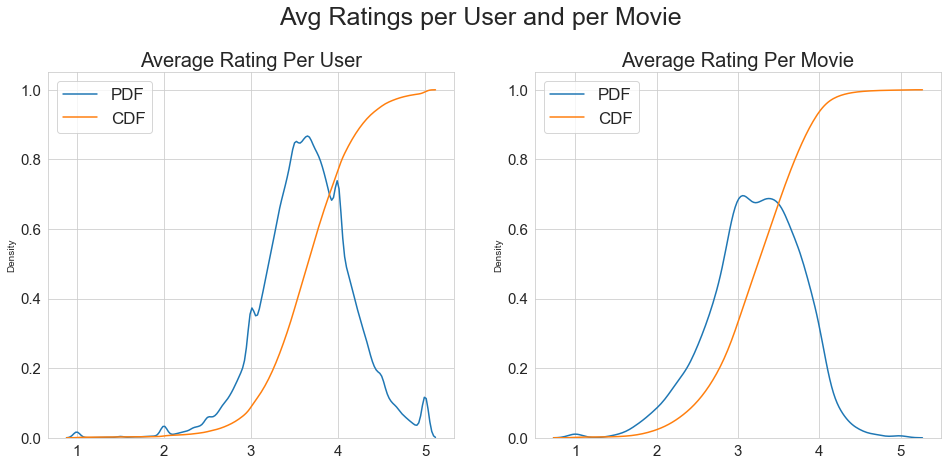

In [72]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (16, 7))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=25)

user_average = [rats for rats in AvgRatingUser.values()]
sns.distplot(user_average, hist = False, ax = axes[0], label = "PDF")
sns.kdeplot(user_average, cumulative = True, ax = axes[0], label = "CDF")
axes[0].set_title("Average Rating Per User", fontsize=20)
axes[0].tick_params(labelsize = 15)
axes[0].legend(loc='upper left', fontsize = 17)

movie_average = [ratm for ratm in AvgRatingMovie.values()]
sns.distplot(movie_average, hist = False, ax = axes[1], label = "PDF")
sns.kdeplot(movie_average, cumulative = True, ax = axes[1], label = "CDF")
axes[1].set_title("Average Rating Per Movie", fontsize=20)
axes[1].tick_params(labelsize = 15)
axes[1].legend(loc='upper left', fontsize = 17)

plt.subplots_adjust(wspace=0.2, top=0.85)
plt.show()

### Cold Start Problem

#### Cold Start Problem with Users

In [73]:
total_users = len(np.unique(Final_Data["CustID"]))
train_users = len(AvgRatingUser)
uncommonUsers = total_users - train_users
                  
print("Total number of Users = {}".format(total_users))
print("Number of Users in train data= {}".format(train_users))
print("Number of Users not present in train data = {}({}%)".format(uncommonUsers, np.round((uncommonUsers/total_users)*100), 2))

Total number of Users = 478723
Number of Users in train data= 401901
Number of Users not present in train data = 76822(16.0%)


#### Cold Start Problem with Movies

In [74]:
total_movies = len(np.unique(Final_Data["MovieID"]))
train_movies = len(AvgRatingMovie)
uncommonMovies = total_movies - train_movies
                  
print("Total number of Movies = {}".format(total_movies))
print("Number of Movies in train data= {}".format(train_movies))
print("Number of Movies not present in train data = {}({}%)".format(uncommonMovies, np.round((uncommonMovies/total_movies)*100), 2))

Total number of Movies = 9114
Number of Movies in train data= 8931
Number of Movies not present in train data = 183(2.0%)


## 4. Computing Similarity Matrices

### Computing User-User Similarity Matrix

Calculating User User Similarity_Matrix is __not very easy__(_unless you have huge Computing Power and lots of time_)

In [75]:
row_index, col_index = TrainUISparseData.nonzero()
rows = np.unique(row_index)
for i in rows[:100]:
    print(i)

6
7
10
25
33
42
59
79
83
87
94
97
131
134
142
149
158
168
169
178
183
188
189
192
195
199
201
242
247
248
261
265
266
267
268
283
291
296
298
299
301
302
304
305
307
308
310
312
314
330
331
333
352
363
368
369
379
383
384
385
392
413
416
424
437
439
440
442
453
462
470
471
477
478
479
481
485
490
491
492
495
508
515
517
527
529
536
540
544
546
550
561
576
585
592
596
602
609
614
616


In [76]:
#Here, we are calculating user-user similarity matrix only for first 100 users in our sparse matrix. And we are calculating 
#top 100 most similar users with them.
def getUser_UserSimilarity(sparseMatrix, top = 100):
    startTimestamp20 = datetime.now()  
    
    row_index, col_index = sparseMatrix.nonzero()  #this will give indices of rows in "row_index" and indices of columns in 
    #"col_index" where there is a non-zero value exist.
    rows = np.unique(row_index)
    similarMatrix = np.zeros(61700).reshape(617,100)    # 617*100 = 61700. As we are building similarity matrix only 
    #for top 100 most similar users.
    timeTaken = []
    howManyDone = 0
    for row in rows[:top]:
        howManyDone += 1
        startTimestamp = datetime.now().timestamp()  #it will give seconds elapsed
        sim = cosine_similarity(sparseMatrix.getrow(row), sparseMatrix).ravel()
        top100_similar_indices = sim.argsort()[-top:]
        top100_similar = sim[top100_similar_indices]
        similarMatrix[row] = top100_similar
        timeforOne = datetime.now().timestamp() - startTimestamp
        timeTaken.append(timeforOne)
        if howManyDone % 20 == 0:
            print("Time elapsed for {} users = {}sec".format(howManyDone, (datetime.now() - startTimestamp20)))
    print("Average Time taken to compute similarity matrix for 1 user = "+str(sum(timeTaken)/len(timeTaken))+"seconds")
    
    fig = plt.figure(figsize = (12,8))
    plt.plot(timeTaken, label = 'Time Taken For Each User')
    plt.plot(np.cumsum(timeTaken), label='Cumulative Time')
    plt.legend(loc='upper left', fontsize = 15)
    plt.xlabel('Users', fontsize = 20)
    plt.ylabel('Time(Seconds)', fontsize = 20)
    plt.tick_params(labelsize = 15)
    plt.show()
    
    return similarMatrix

Time elapsed for 20 users = 0:01:15.375087sec
Time elapsed for 40 users = 0:02:27.427998sec
Time elapsed for 60 users = 0:03:37.367976sec
Time elapsed for 80 users = 0:04:54.744642sec
Time elapsed for 100 users = 0:06:16.558817sec
Average Time taken to compute similarity matrix for 1 user = 3.732189235687256seconds


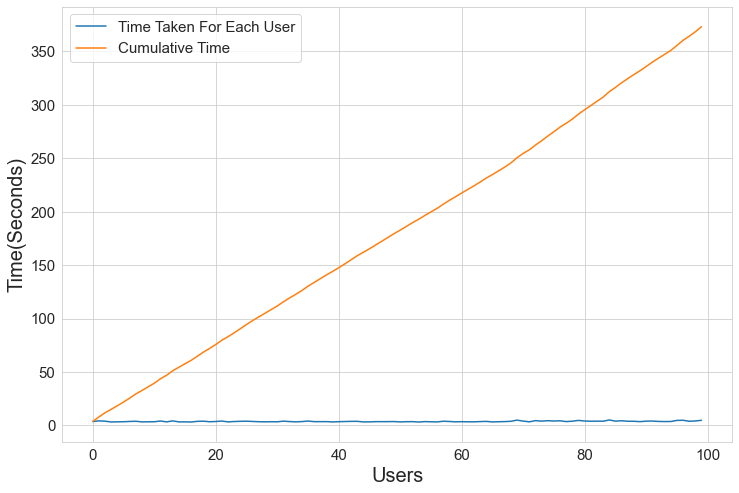

In [77]:
simMatrix = getUser_UserSimilarity(TrainUISparseData, 100)

<p>We have __401901 Users__ in our training data.<br><br>Average time taken to compute similarity matrix for one user is __3.635 sec.__<br><br>For 401901 users:<br><br>_401901*3.635 == 1460910.135sec == 405.808hours == 17Days_<br><br>Computation of user-user similarity matrix is impossible if computational power is limited. On the other hand, if we try to reduce the dimension say by truncated SVD then it would take even more time because truncated SVD creates dense matrix and amount of multiplication for creation of user-user similarity matrix would increase dramatically.<br><br>__Is there any other way to compute user-user similarity???__<br><br>We maintain a binary Vector for users, which tells us whether we already computed similarity for this user or not..<br><br>
__OR__<br><br>Compute top (let's just say, 1000) most similar users for this given user, and add this to our datastructure, so that we can just access it(similar users) without recomputing it again. <br><br>__If it is already computed__<br><br>Just get it directly from our datastructure, which has that information. In production time, We might have to recompute similarities, if it is computed a long time ago. Because user preferences changes over time. If we could maintain some kind of Timer, which when expires, we have to update it ( recompute it ). <br><br>Which datastructure to use:<br><br>It is purely implementation dependant.<br><br>
One simple method is to maintain a **Dictionary Of Dictionaries**.<br><br>

key    :    userid<br>
value  :    Again a dictionary<br>
            key   : _Similar User<br>
            value: Similarity Value>

### Computing Movie-Movie Similarity Matrix

In [78]:
start = datetime.now()

if not os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\m_m_similarity.npz"):
    print("Movie-Movie Similarity file does not exist in your disk. Creating Movie-Movie Similarity Matrix...")
    
    m_m_similarity = cosine_similarity(TrainUISparseData.T, dense_output = False)
    print("Done")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    print("Storing the Movie Similarity matrix on disk for further usage")
    sparse.save_npz(r"C:\Users\Vivek Raj\Desktop\project\netflix\m_m_similarity.npz", m_m_similarity)
else:
    print("File exists in the disk. Loading the file...")
    m_m_similarity = sparse.load_npz(r"C:\Users\Vivek Raj\Desktop\project\netflix\m_m_similarity.npz")
    print("Dimension of Matrix = {}".format(m_m_similarity.shape))
    
print(datetime.now() - start)

File exists in the disk. Loading the file...
Dimension of Matrix = (17771, 17771)
0:00:16.450170


### Does Movie-Movie Similarity Works?
### Let's pick random movie and check it's top 10 most similar movies.

In [79]:
movie_ids = np.unique(m_m_similarity.nonzero())

In [80]:
similar_movies_dict = dict()
for movie in movie_ids:
    smlr = np.argsort(-m_m_similarity[movie].toarray().ravel())[1:100]
    similar_movies_dict[movie] = smlr

In [81]:
movie_titles_df = pd.read_csv(r"C:\Users\Vivek Raj\Desktop\project\netflix\movie_titles.csv",sep = ",", header = None, names=['MovieID', 'Year_of_Release', 'Movie_Title'], index_col = "MovieID", encoding = "iso8859_2")

In [82]:
movie_titles_df.head()

,Year_of_Release,Movie_Title
MovieID,,
1,2003.0,Dinosaur Planet
2,2004.0,Isle of Man TT 2004 Review
3,1997.0,Character
4,1994.0,Paula Abdul's Get Up & Dance
5,2004.0,The Rise and Fall of ECW


### Similar Movies to: __Godzilla's Revenge__

In [83]:
movieID_GR = 17765

print("Name of the movie -------> "+str(movie_titles_df.loc[movieID_GR][1]))

print("Number of ratings by users for movie {} is {}".format(movie_titles_df.loc[movieID_GR][1], TrainUISparseData[:,movieID_GR].getnnz()))

print("Number of similar movies to {} is {}".format(movie_titles_df.loc[movieID_GR][1], m_m_similarity[movieID_GR].count_nonzero()))

Name of the movie -------> Godzilla's Revenge
Number of ratings by users for movie Godzilla's Revenge is 285
Number of similar movies to Godzilla's Revenge is 8863


In [84]:
# Meaning of "[:,17765]" means get all the values of column "17765".
# "getnnz()" give count of explicitly-stored values (nonzeros).

In [85]:
all_similar = sorted(m_m_similarity[movieID_GR].toarray().ravel(), reverse = True)[1:]

similar_100 = all_similar[:101]

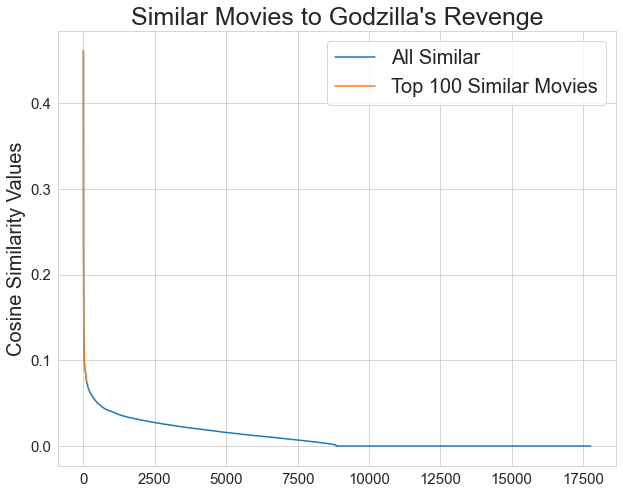

In [86]:
plt.figure(figsize = (10, 8))
plt.plot(all_similar, label = "All Similar")
plt.plot(similar_100, label = "Top 100 Similar Movies")
plt.title("Similar Movies to Godzilla's Revenge", fontsize = 25)
plt.ylabel("Cosine Similarity Values", fontsize = 20)
plt.tick_params(labelsize = 15)
plt.legend(fontsize = 20)
plt.show()

### Top 10 Similar Movies to: __Godzilla's Revenge__

In [87]:
movie_titles_df.loc[similar_movies_dict[movieID_GR][:10]]

,Year_of_Release,Movie_Title
MovieID,,
15810,1964.0,Godzilla vs. Mothra
5907,1956.0,Godzilla: King of the Monsters
14623,1971.0,Godzilla vs. Hedorah
8233,1968.0,Destroy All Monsters
17746,1991.0,Godzilla & Mothra: Battle for Earth / Vs. King...
15123,1995.0,Godzilla vs. Destroyah / Godzilla vs. Space Go...
8601,1997.0,Rebirth of Mothra 1 & 2: Double Feature
8656,1993.0,Godzilla vs. Mechagodzilla II
7140,2003.0,Godzilla: Tokyo S.O.S.


<p>__It seems that Movie-Movie similarity is working perfectly.__</p>

## 5. Machine Learning Models

In [88]:
def get_sample_sparse_matrix(sparseMatrix, n_users, n_movies):
    startTime = datetime.now()
    users, movies, ratings = sparse.find(sparseMatrix)
    uniq_users = np.unique(users)
    uniq_movies = np.unique(movies)
    np.random.seed(15)   #this will give same random number everytime, without replacement
    userS = np.random.choice(uniq_users, n_users, replace = False)
    movieS = np.random.choice(uniq_movies, n_movies, replace = False)
    mask = np.logical_and(np.isin(users, userS), np.isin(movies, movieS))
    sparse_sample = sparse.csr_matrix((ratings[mask], (users[mask], movies[mask])), 
                                                     shape = (max(userS)+1, max(movieS)+1))
    print("Sparse Matrix creation done. Saving it for later use.")
    sparse.save_npz(path, sparse_sample)
    print("Done")
    print("Shape of Sparse Sampled Matrix = "+str(sparse_sample.shape))
    
    print(datetime.now() - start)
    return sparse_sample

### Creating Sample Sparse Matrix for Train Data

In [89]:
path = r"C:\Users\Vivek Raj\Desktop\project\netflix\TrainUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    train_sample_sparse = get_sample_sparse_matrix(TrainUISparseData, 4000, 400)
else:
    print("File is already present in the disk. Loading the file...")
    train_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Train Sample Sparse Matrix = "+str(train_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Train Sample Sparse Matrix = (2649117, 17764)


### Creating Sample Sparse Matrix for Test Data

In [90]:
path = r"C:\Users\Vivek Raj\Desktop\project\netflix\TestUISparseData_Sample.npz"
if not os.path.isfile(path):
    print("Sample sparse matrix is not present in the disk. We are creating it...")
    test_sample_sparse = get_sample_sparse_matrix(TestUISparseData, 2000, 200)
else:
    print("File is already present in the disk. Loading the file...")
    test_sample_sparse = sparse.load_npz(path)
    print("File loading done.")
    print("Shape of Test Sample Sparse Matrix = "+str(test_sample_sparse.shape))

File is already present in the disk. Loading the file...
File loading done.
Shape of Test Sample Sparse Matrix = (2647588, 17689)


### Finding Global Average of all movie ratings, Average rating per User, and Average rating per Movie (from sampled train)

In [91]:
print("Global average of all movies ratings in Train Sample Sparse is {}".format(np.round((train_sample_sparse.sum()/train_sample_sparse.count_nonzero()), 2)))

Global average of all movies ratings in Train Sample Sparse is 3.58


### Finding Average of all movie ratings

In [92]:
globalAvgMovies = getAverageRatings(train_sample_sparse, False)
print("Average move rating for movie 14890 is {}".format(globalAvgMovies[14890]))

Average move rating for movie 14890 is 3.2870967741935484


### Finding Average rating per User

In [93]:
globalAvgUsers = getAverageRatings(train_sample_sparse, True)
print("Average user rating for user 16879 is {}".format(globalAvgMovies[16879]))

Average user rating for user 16879 is 3.738095238095238


### Featurizing data

In [94]:
print("No of ratings in Our Sampled train matrix is : {}".format(train_sample_sparse.count_nonzero()))
print("No of ratings in Our Sampled test matrix is : {}".format(test_sample_sparse.count_nonzero()))

No of ratings in Our Sampled train matrix is : 19214
No of ratings in Our Sampled test matrix is : 1150


### Featurizing data for regression problem

### Featurizing Train Data

In [95]:
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(train_sample_sparse)

In [165]:
# u=sample_train_users
# x=cosine_similarity(train_sample_sparse[u[0]], train_sample_sparse).ravel()
# np.argsort(-u)[1:]
x=np.array([3,2,4,6,1])
np.argsort(-x)[1:]

array([2, 0, 1, 4], dtype=int64)

In [96]:
if os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\Train_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Train csv file for {} rows".format(len(sample_train_ratings)))
    with open(r"C:\Users\Vivek Raj\Desktop\project\netflix\Train_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#----------------------------------Ratings given to "movie" by top 5 similar users with "user"--------------------#
            similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
            similar_users_indices = np.argsort(-similar_users)[1:]
            similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
            top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
            top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
            row.extend(top_similar_user_ratings)
            
 #----------------------------------Ratings given by "user" to top 5 similar movies with "movie"------------------#
            similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
            similar_movies_indices = np.argsort(-similar_movies)[1:]
            similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
            top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
            top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
            #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" average
            #rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
            row.extend(top_similar_movie_ratings)
            
 #----------------------------------Appending "user" average, "movie" average & rating of "user""movie"-----------#
            row.append(globalAvgUsers[user])
            row.append(globalAvgMovies[movie])
            row.append(rating)
            
#-----------------------------------Converting rows and appending them as comma separated values to csv file------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 2000 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_train_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [97]:
Train_Reg = pd.read_csv(r"C:\Users\Vivek Raj\Desktop\project\netflix\Train_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,4.0,2.0,2.0,2.900000,2.5,1
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.388889,2.5,2
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,5.0,4.250000,2.5,4
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,4.0,5.0,3.0,3.458333,2.5,3
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,5.0,4.038462,2.5,4


In [171]:
Train_Reg.describe()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
count,1.921400e+04,19214.000000,1.921400e+04,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,...,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000,19214.000000
mean,1.341306e+06,11538.321745,3.582804e+00,3.733319,3.741543,3.733788,3.711356,3.756584,3.712397,3.669824,...,3.603883,3.602477,3.582804,3.582804,3.582804,3.573123,3.592635,3.583187,3.580405,3.571485
std,7.714045e+05,4724.996134,1.825254e-13,1.003443,1.013378,1.008319,1.014952,1.015766,1.040799,1.034847,...,1.004021,0.977661,0.583872,0.378291,1.087485,0.559209,0.902927,0.994457,0.490151,0.589770
min,1.893000e+03,4512.000000,3.582804e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.028380,1.000000,1.000000,1.142190,1.000000
25%,6.500880e+05,6337.000000,3.582804e+00,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,3.000000,3.000000,3.225000,3.381729,3.000000,3.216851,3.000218,3.000000,3.278799,3.197507
50%,1.361896e+06,13973.000000,3.582804e+00,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,3.571429,3.553872,4.000000,3.581187,3.824156,3.858650,3.581885,3.594990
75%,2.019936e+06,15755.000000,3.582804e+00,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,4.000000,...,4.000000,4.000000,4.000000,3.887410,4.000000,3.952123,4.141920,4.093359,3.910706,3.983387
max,2.649116e+06,17763.000000,3.582804e+00,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [98]:
print("Number of nan Values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan Values = 0


<p><b>User_ID:</b> ID of a this User</p>

<p><b>Movie_ID:</b> ID of a this Movie</p>

<p><b>Global_Average:</b> Global Average Rating</p>

<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>
   
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>

<p><b>User_Average:</b> Average Rating of this User</p>

<p><b>Movie_Average:</b> Average Rating of this Movie</p>

<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [99]:
print("Shape of Train DataFrame = {}".format(Train_Reg.shape))

Shape of Train DataFrame = (19214, 16)


### Featurizing Test Data

In [100]:
sample_test_users, sample_test_movies, sample_test_ratings = sparse.find(test_sample_sparse)

In [101]:
if os.path.isfile(r"C:\Users\Vivek Raj\Desktop\project\netflix\Test_Regression.csv"):
    print("File is already present in your disk. You do not have to prepare it again.")
else:
    startTime = datetime.now()
    print("Preparing Test csv file for {} rows".format(len(sample_test_ratings)))
    with open(r"C:\Users\Vivek Raj\Desktop\project\netflix\Test_Regression.csv", mode = "w") as data:
        count = 0
        for user, movie, rating in zip(sample_test_users, sample_test_movies, sample_test_ratings):
            row = list()
            row.append(user)  #appending user ID
            row.append(movie) #appending movie ID
            row.append(train_sample_sparse.sum()/train_sample_sparse.count_nonzero()) #appending global average rating

#-----------------------------Ratings given to "movie" by top 5 similar users with "user"-------------------------#
            try:
                similar_users = cosine_similarity(train_sample_sparse[user], train_sample_sparse).ravel()
                similar_users_indices = np.argsort(-similar_users)[1:]
                similar_users_ratings = train_sample_sparse[similar_users_indices, movie].toarray().ravel()
                top_similar_user_ratings = list(similar_users_ratings[similar_users_ratings != 0][:5])
                top_similar_user_ratings.extend([globalAvgMovies[movie]]*(5-len(top_similar_user_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "movie" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "movie" average rating.
                row.extend(top_similar_user_ratings)
            #########Cold Start Problem, for a new user or a new movie#########    
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Ratings given by "user" to top 5 similar movies with "movie"-----------------------#
            try:
                similar_movies = cosine_similarity(train_sample_sparse[:,movie].T, train_sample_sparse.T).ravel()
                similar_movies_indices = np.argsort(-similar_movies)[1:]
                similar_movies_ratings = train_sample_sparse[user, similar_movies_indices].toarray().ravel()
                top_similar_movie_ratings = list(similar_movies_ratings[similar_movies_ratings != 0][:5])
                top_similar_movie_ratings.extend([globalAvgUsers[user]]*(5-len(top_similar_movie_ratings)))
                #above line means that if top 5 ratings are not available then rest of the ratings will be filled by "user" 
                #average rating. Let say only 3 out of 5 ratings are available then rest 2 will be "user" average rating.
                row.extend(top_similar_movie_ratings)
            #########Cold Start Problem, for a new user or a new movie#########
            except(IndexError, KeyError):
                global_average_train_rating = [train_sample_sparse.sum()/train_sample_sparse.count_nonzero()]*5
                row.extend(global_average_train_rating)
            except:
                raise
                
 #-----------------------------Appending "user" average, "movie" average & rating of "user""movie"----------------#
            try:        
                row.append(globalAvgUsers[user])
            except (KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            try:
                row.append(globalAvgMovies[movie])
            except(KeyError):
                global_average_train_rating = train_sample_sparse.sum()/train_sample_sparse.count_nonzero()
                row.append(global_average_train_rating)
            except:
                raise
                
            row.append(rating)
            
#------------------------------Converting rows and appending them as comma separated values to csv file-----------#
            data.write(",".join(map(str, row)))
            data.write("\n")
    
            count += 1
            if count % 100 == 0:
                print("Done for {}. Time elapsed: {}".format(count, (datetime.now() - startTime)))
                
    print("Total Time for {} rows = {}".format(len(sample_test_ratings), (datetime.now() - startTime)))

File is already present in your disk. You do not have to prepare it again.


In [103]:
Test_Reg = pd.read_csv(r"C:\Users\Vivek Raj\Desktop\project\netflix\Test_Regression.csv", names = ["User_ID", "Movie_ID", "Global_Average", "SUR1", "SUR2", "SUR3", "SUR4", "SUR5", "SMR1", "SMR2", "SMR3", "SMR4", "SMR5", "User_Average", "Movie_Average", "Rating"])
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5


In [104]:
print("Number of nan Values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan Values = 0


<p><b>User_ID:</b> ID of a this User</p>



<p><b>Movie_ID:</b> ID of a this Movie</p>



<p><b>Global_Average:</b> Global Average Rating</p>



<p><b>Ratings given to this Movie by top 5 similar users with this User:</b> (SUR1, SUR2, SUR3, SUR4, SUR5)</p>

    
    
<p><b>Ratings given by this User to top 5 similar movies with this Movie:</b> (SMR1, SMR2, SMR3, SMR4, SMR5)</p>


<p><b>User_Average:</b> Average Rating of this User</p>


<p><b>Movie_Average:</b> Average Rating of this Movie</p>


<p><b>Rating:</b> Rating given by this User to this Movie</p>

In [105]:
print("Shape of Test DataFrame = {}".format(Test_Reg.shape))

Shape of Test DataFrame = (1150, 16)


### Transforming Data for Surprise Models

#### Transforming Train Data

- We can't give raw data (movie, user, rating) to train the model in Surprise library.


- They have a separate format for TRAIN and TEST data, which will be useful for training the models like SVD, KNNBaseLineOnly....etc..,in Surprise.


- We can form the trainset from a file, or from a Pandas  DataFrame. 
http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py 

In [106]:
Train_Reg[['User_ID', 'Movie_ID', 'Rating']].head(5)

,User_ID,Movie_ID,Rating
0,180921,4512,1
1,210185,4512,2
2,218038,4512,4
3,221936,4512,3
4,370736,4512,4


In [107]:
reader = Reader(rating_scale=(1, 5))

data = Dataset.load_from_df(Train_Reg[['User_ID', 'Movie_ID', 'Rating']], reader)

trainset = data.build_full_trainset()

#### Transforming Test Data

- For test data we just have to define a tuple (user, item, rating).
- You can check out this link: https://github.com/NicolasHug/Surprise/commit/86cf44529ca0bbb97759b81d1716ff547b950812
- Above link is a github of surprise library. Check methods "def all_ratings(self)" and "def build_testset(self)" from line
  177 to 201(If they modify the file then line number may differ, but you can always check aforementioned two methods).
- "def build_testset(self)" method returns a list of tuples of (user, item, rating).

In [108]:
testset = list(zip(Test_Reg["User_ID"].values, Test_Reg["Movie_ID"].values, Test_Reg["Rating"].values))

In [109]:
testset[:5]

[(464626, 4614, 3),
 (1815614, 4627, 3),
 (2298717, 4627, 5),
 (2532402, 4627, 4),
 (2027, 4798, 5)]

### Applying Machine Learning Models

<p>We have two Error Metrics.</p>
<p><b>->   RMSE: Root Mean Square Error: </b>RMSE is the error of each point which is squared. Then mean is calculated. Finally root of that mean is taken as final value.</p>
<p><b>->   MAPE: Mean Absolute Percentage Error: </b>The mean absolute percentage error (MAPE), also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method.</p>
<p>where At is the actual value and Ft is the forecast value.</p>
<p>
The difference between At and Ft is divided by the actual value At again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.</p>

<b>We can also use other regression models. But  we are using exclusively XGBoost as it is typically fairly powerful in practice.</b>

In [110]:
error_table = pd.DataFrame(columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"])
model_train_evaluation = dict()
model_test_evaluation = dict()

In [111]:
def make_table(model_name, rmse_train, mape_train, rmse_test, mape_test):
    global error_table
    #All variable assignments in a function store the value in the local symbol table; whereas variable references first look 
    #in the local symbol table, then in the global symbol table, and then in the table of built-in names. Thus, global variables 
    #cannot be directly assigned a value within a function (unless named in a global statement), 
    #although they may be referenced.
    error_table = error_table.append(pd.DataFrame([[model_name, rmse_train, mape_train, rmse_test, mape_test]], columns = ["Model", "Train RMSE", "Train MAPE", "Test RMSE", "Test MAPE"]))
    error_table.reset_index(drop = True, inplace = True)

### Utility Functions for Regression Models

In [112]:
def error_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(abs((y_true - y_pred)/y_true))*100
    return rmse, mape

In [113]:
def train_test_xgboost(x_train, x_test, y_train, y_test, model_name):
    startTime = datetime.now()
    train_result = dict()
    test_result = dict()
    
    clf = xgb.XGBRegressor(n_estimators = 100, silent = False, n_jobs  = 10)
    clf.fit(x_train, y_train)
    
    print("-"*50)
    print("TRAIN DATA")
    y_pred_train = clf.predict(x_train)
    rmse_train, mape_train = error_metrics(y_train, y_pred_train)
    print("RMSE = {}".format(rmse_train))
    print("MAPE = {}".format(mape_train))
    print("-"*50)
    train_result = {"RMSE": rmse_train, "MAPE": mape_train, "Prediction": y_pred_train}
    
    print("TEST DATA")
    y_pred_test = clf.predict(x_test)
    rmse_test, mape_test = error_metrics(y_test, y_pred_test)
    print("RMSE = {}".format(rmse_test))
    print("MAPE = {}".format(mape_test))
    print("-"*50)
    test_result = {"RMSE": rmse_test, "MAPE": mape_test, "Prediction": y_pred_test}
        
    print("Time Taken = "+str(datetime.now() - startTime))
    
    plot_importance(xgb, clf)
    
    make_table(model_name, rmse_train, mape_train, rmse_test, mape_test)
    
    return train_result, test_result

In [114]:
def plot_importance(model, clf):
    fig = plt.figure(figsize = (8, 6))
    ax = fig.add_axes([0,0,1,1])
    model.plot_importance(clf, ax = ax, height = 0.3)
    plt.xlabel("F Score", fontsize = 20)
    plt.ylabel("Features", fontsize = 20)
    plt.title("Feature Importance", fontsize = 20)
    plt.tick_params(labelsize = 15)
    
    plt.show()

### Utility Functions for Surprise Models

In [115]:
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    predicted = np.array([pred.est for pred in predictions])
    return actual, predicted
#in surprise prediction of every data point is returned as dictionary like this:
#"user: 196        item: 302        r_ui = 4.00   est = 4.06   {'actual_k': 40, 'was_impossible': False}"
#In this dictionary, "r_ui" is a key for actual rating and "est" is a key for predicted rating 

In [116]:
def get_error(predictions):
    actual, predicted = get_ratings(predictions)
    rmse = np.sqrt(mean_squared_error(actual, predicted)) 
    mape = np.mean(abs((actual - predicted)/actual))*100
    return rmse, mape

In [117]:
my_seed = 15
random.seed(my_seed)
np.random.seed(my_seed)

def run_surprise(algo, trainset, testset, model_name):
    startTime = datetime.now()
    
    train = dict()
    test = dict()
    
    algo.fit(trainset)
    #You can check out above function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    
#-----------------Evaluating Train Data------------------#
    print("-"*50)
    print("TRAIN DATA")
    train_pred = algo.test(trainset.build_testset())
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    #You can check out "trainset.build_testset()" function at "https://surprise.readthedocs.io/en/stable/FAQ.html#can-i-use-my-own-dataset-with-surprise-and-can-it-be-a-pandas-dataframe" in 
    #"How to get accuracy measures on the training set" section
    train_actual, train_predicted = get_ratings(train_pred)
    train_rmse, train_mape = get_error(train_pred)
    print("RMSE = {}".format(train_rmse))
    print("MAPE = {}".format(train_mape))
    print("-"*50)
    train = {"RMSE": train_rmse, "MAPE": train_mape, "Prediction": train_predicted}
    
#-----------------Evaluating Test Data------------------#
    print("TEST DATA")
    test_pred = algo.test(testset)
    #You can check out "algo.test()" function at "https://surprise.readthedocs.io/en/stable/getting_started.html" in 
    #"Train-test split and the fit() method" section
    test_actual, test_predicted = get_ratings(test_pred)
    test_rmse, test_mape = get_error(test_pred)
    print("RMSE = {}".format(test_rmse))
    print("MAPE = {}".format(test_mape))
    print("-"*50)
    test = {"RMSE": test_rmse, "MAPE": test_mape, "Prediction": test_predicted}
    
    print("Time Taken = "+str(datetime.now() - startTime))
    
    make_table(model_name, train_rmse, train_mape, test_rmse, test_mape)
    
    return train, test

## 1. XGBoost 13 Features

[00:11:52] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.6051474633464521
MAPE = 16.547967493534088
--------------------------------------------------
TEST DATA
RMSE = 1.1226487142559078
MAPE = 32.010038277723
--------------------------------------------------
Time Taken = 0:00:01.577970


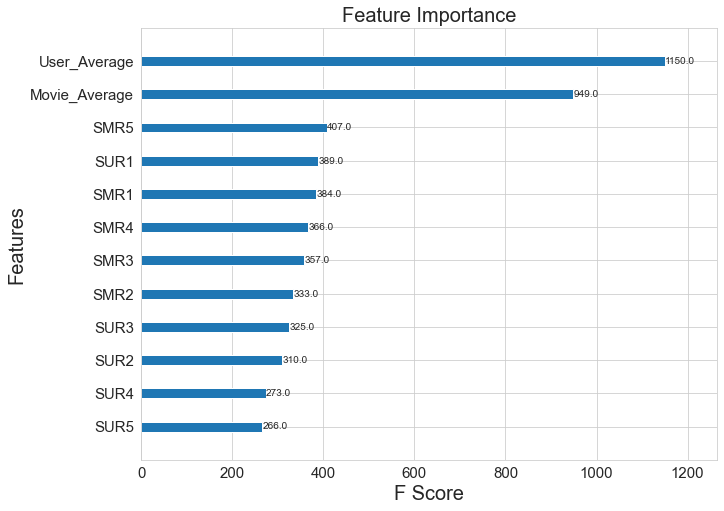

In [118]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGBoost_13")

model_train_evaluation["XGBoost_13"] = train_result
model_test_evaluation["XGBoost_13"] = test_result

## 2. Surprise BaselineOnly Model

### Predicted Rating
> $\large\hat{r}_{ui} = \mu + b_u + b_i$<br><br>

- $\mu$: Average Global Ratings in training data<br>
- $b_u$: User-Bias<br>
- $b_i$: Item-Bias

### Optimization Function
> $\large \sum_{r_ui \in R_{Train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 + \lambda \left(b_u^2 + b_i^2 \right). \left[minimize\; b_u, b_i \right]$

In [119]:
bsl_options = {"method":"sgd", "learning_rate":0.01, "n_epochs":25}

algo = BaselineOnly(bsl_options=bsl_options)
#You can check the docs of above used functions at:https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration
#at section "Baselines estimates configuration".

train_result, test_result = run_surprise(algo, trainset, testset, "BaselineOnly")

model_train_evaluation["BaselineOnly"] = train_result
model_test_evaluation["BaselineOnly"] = test_result

Estimating biases using sgd...
--------------------------------------------------
TRAIN DATA
RMSE = 0.8811426214928658
MAPE = 27.158727146074078
--------------------------------------------------
TEST DATA
RMSE = 1.0678388468431512
MAPE = 33.39729060309592
--------------------------------------------------
Time Taken = 0:00:01.422030


## 3. XGBoost 13 Features + Surprise BaselineOnly Model

### Adding predicted ratings from Surprise BaselineOnly model to our Train and Test Dataframe

In [120]:
Train_Reg["BaselineOnly"] = model_train_evaluation["BaselineOnly"]["Prediction"]

In [121]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,4.0,2.0,2.0,2.900000,2.5,1,2.077166
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.388889,2.5,2,2.916411
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,5.0,4.250000,2.5,4,2.905264
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,4.0,5.0,3.0,3.458333,2.5,3,3.290933
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,5.0,4.038462,2.5,4,3.561135


In [122]:
print("Number of nan values = "+str(Train_Reg.isnull().sum().sum()))

Number of nan values = 0


In [123]:
Test_Reg["BaselineOnly"] = model_test_evaluation["BaselineOnly"]["Prediction"]
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804


In [124]:
print("Number of nan values = "+str(Test_Reg.isnull().sum().sum()))

Number of nan values = 0


[00:12:11] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.5949516863142196
MAPE = 16.334639489650726
--------------------------------------------------
TEST DATA
RMSE = 1.2562482311411585
MAPE = 30.663328753001164
--------------------------------------------------
Time Taken = 0:00:02.312194


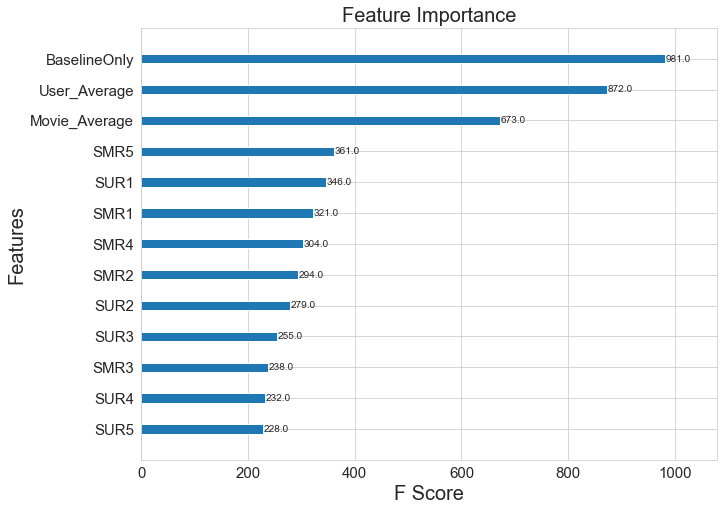

In [125]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL")

model_train_evaluation["XGB_BSL"] = train_result
model_test_evaluation["XGB_BSL"] = test_result

## 4. Surprise KNN-Baseline with User-User and Item-Item Similarity

### Prediction $\hat{r}_{ui}$ in case of user-user similarity

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v
\in N^k_i(u)} \text{sim}(u, v)}$

- $\pmb{b_{ui}}$ - Baseline prediction_ of (user,movie) rating which is "$b_{ui} = \mu + b_u + b_i$".

- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  

- _sim (u, v)_ - Similarity between users __u and v__ who also rated movie 'i'. This is exactly same as our hand-crafted features 'SUR'- 'Similar User Rating'. Means here we have taken 'k' such similar users 'v' with user 'u' who also rated movie 'i'. $r_{vi}$ is the rating which user 'v' gives on item 'i'. $b_{vi}$ is the predicted baseline model rating of user 'v' on item 'i'.
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take     - base line predictions instead of mean rating of user/item)<br><br><br><br>  

### Prediction $\hat{r}_{ui}$ in case of item-item similarity

$\large \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}
\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in
N^k_u(j)} \text{sim}(i, j)}$

- __Notation is same as of user-user similarity__<br><br><br>


#### Documentation you can check at:
KNN BASELINE: https://surprise.readthedocs.io/en/stable/knn_inspired.html

PEARSON_BASELINE SIMILARITY: http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline

SHRINKAGE: Neighborhood Models in http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf

### 4.1 Surprise KNN-Baseline with User-User.

#### Cross- Validation

In [126]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [True], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

### Applying KNNBaseline User-User with best parameters

In [127]:
sim_options = {'name':'pearson_baseline', 'user_based':True, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_User")

model_train_evaluation["KNNBaseline_User"] = train_result
model_test_evaluation["KNNBaseline_User"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.3044975188091617
MAPE = 8.090955152033715
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:28.081552


### 4.2 Surprise KNN-Baseline with Item-Item.

#### Cross- Validation

In [128]:
param_grid  = {'sim_options':{'name': ["pearson_baseline"], "user_based": [False], "min_support": [2], "shrinkage": [60, 80, 80, 140]}, 'k': [5, 20, 40, 80]}

gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline si

#### Applying KNNBaseline Item-Item with best parameters

In [129]:
sim_options = {'name':'pearson_baseline', 'user_based':False, 'min_support':2, 'shrinkage':gs.best_params['rmse']['sim_options']['shrinkage']}

bsl_options = {'method': 'sgd'} 

algo = KNNBaseline(k = gs.best_params['rmse']['k'], sim_options = sim_options, bsl_options=bsl_options)

train_result, test_result = run_surprise(algo, trainset, testset, "KNNBaseline_Item")

model_train_evaluation["KNNBaseline_Item"] = train_result
model_test_evaluation["KNNBaseline_Item"] = test_result

Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
--------------------------------------------------
TRAIN DATA
RMSE = 0.18165138844472184
MAPE = 4.245794665995157
--------------------------------------------------
TEST DATA
RMSE = 1.067654798722828
MAPE = 33.39814334762251
--------------------------------------------------
Time Taken = 0:00:01.973037


## 5. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline

### Adding predicted ratings from Surprise KNN Baseline model to our Train and Test Dataframe

In [130]:
Train_Reg["KNNBaseline_User"] = model_train_evaluation["KNNBaseline_User"]["Prediction"]
Train_Reg["KNNBaseline_Item"] = model_train_evaluation["KNNBaseline_Item"]["Prediction"]

Test_Reg["KNNBaseline_User"] = model_test_evaluation["KNNBaseline_User"]["Prediction"]
Test_Reg["KNNBaseline_Item"] = model_test_evaluation["KNNBaseline_Item"]["Prediction"]

In [131]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,4.0,2.0,2.0,2.900000,2.5,1,2.077166,1.193482,1.076235
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,3.0,4.0,4.0,3.388889,2.5,2,2.916411,2.246199,2.014904
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,4.0,3.0,5.0,4.250000,2.5,4,2.905264,3.727792,3.653776
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,4.0,5.0,3.0,3.458333,2.5,3,3.290933,3.097569,2.961074
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,4.0,4.0,5.0,4.038462,2.5,4,3.561135,3.042586,3.105870


In [132]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [133]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,SMR3,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,4,3.582804,3.582804,3.582804
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804


In [134]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


[00:32:22] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.5884776139759752
MAPE = 16.365784406661987
--------------------------------------------------
TEST DATA
RMSE = 1.146172457501923
MAPE = 31.64374059974294
--------------------------------------------------
Time Taken = 0:00:01.912037


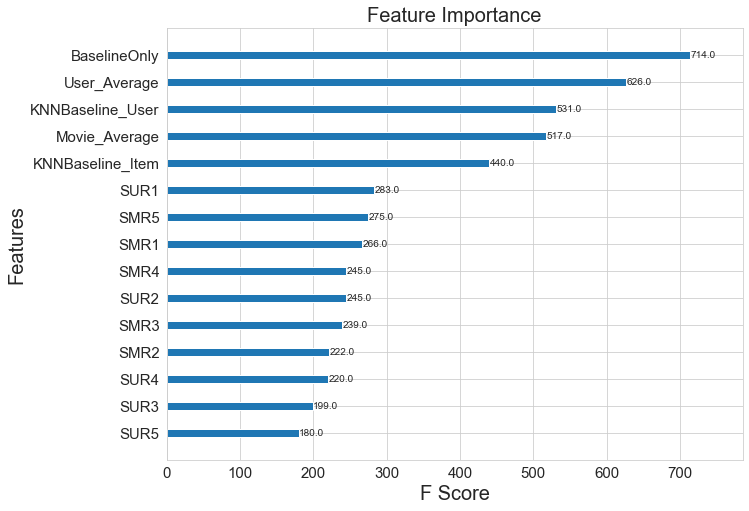

In [135]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN")

model_train_evaluation["XGB_BSL_KNN"] = train_result
model_test_evaluation["XGB_BSL_KNN"] = test_result

## 6. Matrix Factorization SVD 

#### Prediction $\hat{r}_{ui}$ is set as:<br>

$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$
- $\pmb q_i$ - Representation of item(movie) in latent factor space
        
- $\pmb p_u$ - Representation of user in new latent factor space<br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$ and $q_i$.__<br><br><br>


#### Optimization Problem<br>

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) \left[minimize\; b_u, b_i, q_i, p_u \right]$
<br><br><br>

SVD Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

#### Cross- Validation

In [136]:
param_grid  = {'n_factors': [5,7,10,15,20,25,35,50,70,90]}   #here, n_factors is the equivalent to dimension 'd' when matrix 'A'
#is broken into 'b' and 'c'. So, matrix 'A' will be of dimension n*m. So, matrices 'b' and 'c' will be of dimension n*d and m*d.

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9928795503593242
{'n_factors': 7}


### Applying SVD with best parameters

In [137]:
algo = SVD(n_factors = gs.best_params['rmse']['n_factors'], biased=True, verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVD")

model_train_evaluation["SVD"] = train_result
model_test_evaluation["SVD"] = test_result

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.8915292018008784
MAPE = 27.929401130209502
--------------------------------------------------
TEST DATA
RMSE = 1.0676633276455576
MAPE = 33.39843901285594
--------------------------------------------------
Time Taken = 0:00:01.292639


## 7. Matrix Factorization SVDpp with implicit feedback

#### Prediction $\hat{r}_{ui}$ is set as:<br>
$\large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
|I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right)$<br><br>

 - $ \pmb{I_u}$ --- the set of all items rated by user u. $|I_u|$ is a length of that set.<br>

-  $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings. Here, an implicit rating describes the fact that a user u rated an item j, regardless of the rating value. $y_i$ is an item vector. For every item j, there is an item vector $y_j$ which is an implicit feedback. Implicit feedback indirectly reflects opinion by observing user behavior including purchase history, browsing history, search patterns, or even mouse movements. Implicit feedback usually denotes the presence or absence of an event. For example, there is a movie 10 where user has just checked the details of the movie and spend some time there, will contribute to implicit rating. Now, since here Netflix has not provided us the details that for how long a user has spend time on the movie, so here we are considering the fact that even if a user has rated some movie then it means that he has spend some time on that movie which contributes to implicit rating.<br><br>

__If user u is unknown, then the bias $b_u$ and the factors $p_u$ are assumed to be zero. The same applies for item i with $b_i$, $q_i$ and $y_i$.__<br><br><br>

#### Optimization Problem

$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right).\left[minimize\; b_u, b_i, q_i, p_u, y_j \right]$<br><br>

SVDpp Documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

#### Cross- Validation

In [138]:
param_grid = {'n_factors': [10, 30, 50, 80, 100], 'lr_all': [0.002, 0.006, 0.018, 0.054, 0.10]}

gs = GridSearchCV(SVDpp, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.9857877246085246
{'n_factors': 10, 'lr_all': 0.006}


#### Applying SVDpp with best parameters

In [139]:
algo = SVDpp(n_factors = gs.best_params['rmse']['n_factors'], lr_all = gs.best_params['rmse']["lr_all"], verbose=True)

train_result, test_result = run_surprise(algo, trainset, testset, "SVDpp")

model_train_evaluation["SVDpp"] = train_result
model_test_evaluation["SVDpp"] = test_result

 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19
--------------------------------------------------
TRAIN DATA
RMSE = 0.793069836701297
MAPE = 24.331089234704926
--------------------------------------------------
TEST DATA
RMSE = 1.0676735672268267
MAPE = 33.3956791755603
--------------------------------------------------
Time Taken = 0:00:12.400730


## 8. XGBoost 13 Features + Surprise BaselineOnly + Surprise KNN Baseline + SVD + SVDpp

In [140]:
Train_Reg["SVD"] = model_train_evaluation["SVD"]["Prediction"]
Train_Reg["SVDpp"] = model_train_evaluation["SVDpp"]["Prediction"]

Test_Reg["SVD"] = model_test_evaluation["SVD"]["Prediction"]
Test_Reg["SVDpp"] = model_test_evaluation["SVDpp"]["Prediction"]

In [141]:
Train_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,180921,4512,3.582804,3.0,2.0,1.0,2.0,1.0,4.0,3.0,...,2.0,2.0,2.900000,2.5,1,2.077166,1.193482,1.076235,2.237030,2.231730
1,210185,4512,3.582804,2.0,1.0,3.0,3.0,4.0,3.0,3.0,...,4.0,4.0,3.388889,2.5,2,2.916411,2.246199,2.014904,3.050194,2.752852
2,218038,4512,3.582804,2.0,3.0,3.0,2.0,4.0,4.0,4.0,...,3.0,5.0,4.250000,2.5,4,2.905264,3.727792,3.653776,3.037636,3.159202
3,221936,4512,3.582804,4.0,2.0,2.0,1.0,2.0,3.0,4.0,...,5.0,3.0,3.458333,2.5,3,3.290933,3.097569,2.961074,3.443622,3.291811
4,370736,4512,3.582804,2.0,4.0,1.0,2.0,2.0,4.0,4.0,...,4.0,5.0,4.038462,2.5,4,3.561135,3.042586,3.105870,3.806972,3.495492


In [142]:
print("Number of nan values in Train Data "+str(Train_Reg.isnull().sum().sum()))

Number of nan values in Train Data 0


In [143]:
Test_Reg.head()

,User_ID,Movie_ID,Global_Average,SUR1,SUR2,SUR3,SUR4,SUR5,SMR1,SMR2,...,SMR4,SMR5,User_Average,Movie_Average,Rating,BaselineOnly,KNNBaseline_User,KNNBaseline_Item,SVD,SVDpp
0,464626,4614,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804,3.582804,3.582804
1,1815614,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,3,3.582804,3.582804,3.582804,3.582804,3.582804
2,2298717,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804,3.582804,3.582804
3,2532402,4627,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,4,3.582804,3.582804,3.582804,3.582804,3.582804
4,2027,4798,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,3.582804,...,3.582804,3.582804,3.582804,3.582804,5,3.582804,3.582804,3.582804,3.582804,3.582804


In [144]:
print("Number of nan values in Test Data "+str(Test_Reg.isnull().sum().sum()))

Number of nan values in Test Data 0


[00:50:36] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.5828093439473843
MAPE = 16.276511549949646
--------------------------------------------------
TEST DATA
RMSE = 1.129455324311166
MAPE = 31.89130551607692
--------------------------------------------------
Time Taken = 0:00:03.059843


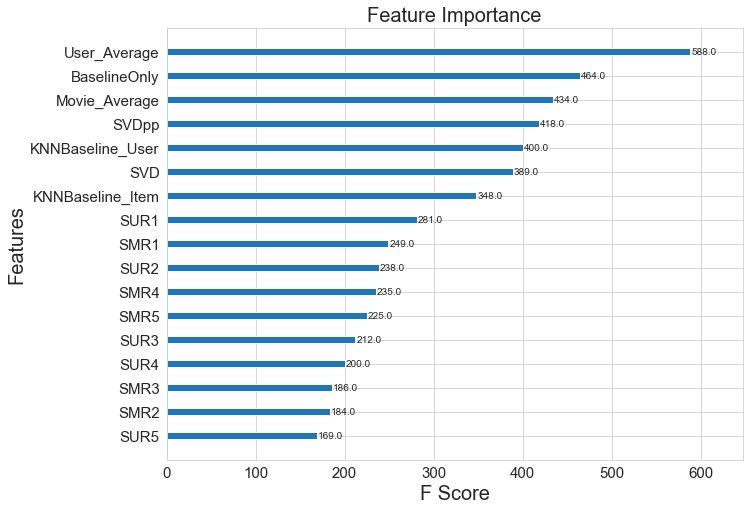

In [145]:
x_train = Train_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

x_test = Test_Reg.drop(["User_ID", "Movie_ID", "Rating"], axis = 1)

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_BSL_KNN_MF")

model_train_evaluation["XGB_BSL_KNN_MF"] = train_result
model_test_evaluation["XGB_BSL_KNN_MF"] = test_result

## 9. Surprise KNN Baseline + SVD + SVDpp

[00:50:40] WARNING: ..\src\learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


--------------------------------------------------
TRAIN DATA
RMSE = 0.9222947113371508
MAPE = 29.60980534553528
--------------------------------------------------
TEST DATA
RMSE = 1.0746159984412627
MAPE = 33.245188892751834
--------------------------------------------------
Time Taken = 0:00:02.318422


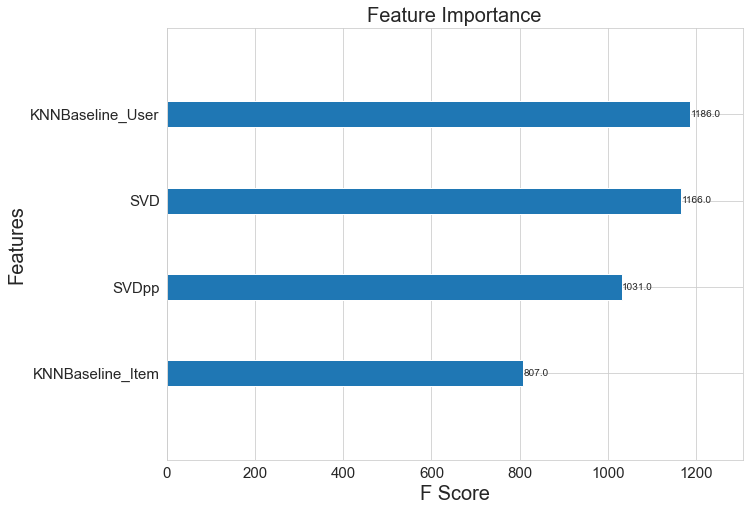

In [146]:
x_train = Train_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

x_test = Test_Reg[["KNNBaseline_User", "KNNBaseline_Item", "SVD", "SVDpp"]]

y_train = Train_Reg["Rating"]

y_test = Test_Reg["Rating"]

train_result, test_result = train_test_xgboost(x_train, x_test, y_train, y_test, "XGB_KNN_MF")

model_train_evaluation["XGB_KNN_MF"] = train_result
model_test_evaluation["XGB_KNN_MF"] = test_result

## Summary

In [147]:
error_table2 = error_table.drop(["Train MAPE", "Test MAPE"], axis = 1)

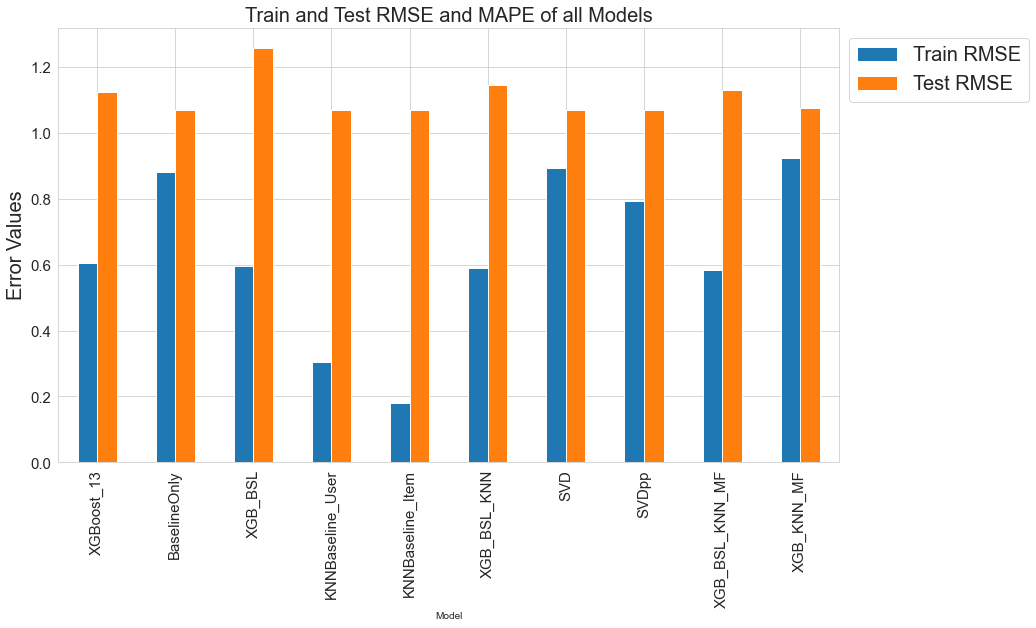

In [148]:
error_table2.plot(x = "Model", kind = "bar", figsize = (14, 8), grid = True, fontsize = 15)
plt.title("Train and Test RMSE and MAPE of all Models", fontsize = 20)
plt.ylabel("Error Values", fontsize = 20)
plt.legend(bbox_to_anchor=(1, 1), fontsize = 20)
plt.show()

In [149]:
error_table.drop(["Train MAPE", "Test MAPE"], axis = 1).style.highlight_min(axis=0)

,Model,Train RMSE,Test RMSE
0,XGBoost_13,0.605147,1.122649
1,BaselineOnly,0.881143,1.067839
2,XGB_BSL,0.594952,1.256248
3,KNNBaseline_User,0.304498,1.067655
4,KNNBaseline_Item,0.181651,1.067655
5,XGB_BSL_KNN,0.588478,1.146172
6,SVD,0.891529,1.067663
7,SVDpp,0.793070,1.067674
8,XGB_BSL_KNN_MF,0.582809,1.129455
9,XGB_KNN_MF,0.922295,1.074616


# So, far our best model is SVDpp with Test RMSE of 1.067583